### Maxwell-equal area construction for a Van-der waal's gas
-Vir Karan


The equation of state in non-dimensional form is:
P = 8T/(3v-1) - 3/v^2

The code logic for the equal area construction is based on [this page.](https://kitchingroup.cheme.cmu.edu/blog/2013/02/15/The-equal-area-method-for-the-van-der-Waals-equation/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

First let's look at the variation of pressure with density (for convenience, we'll use the inverse of density here, makes convergence a bit easier). We'll also make use of the dimensionless form of the equation of state.

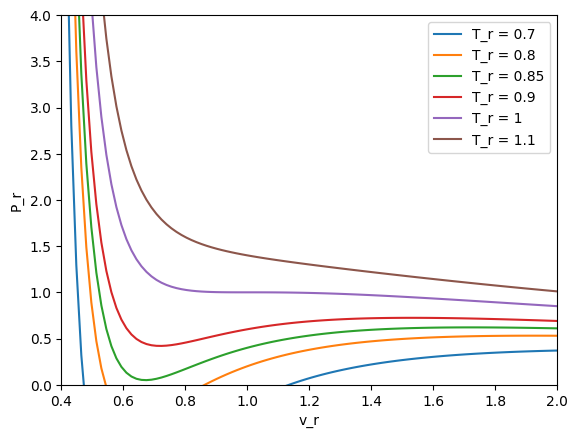

In [3]:
T_r = 0.9
def P(v_r, T_r):
    '''Function to compute (P/P_c) from the equation of state.'''
    return 8*T_r/(3*v_r - 1) - 3/(v_r*v_r)

v_r = np.linspace(0.4, 2, 100)
plt.plot(v_r, P(v_r, 0.7), label='T_r = 0.7')
plt.plot(v_r, P(v_r, 0.8), label='T_r = 0.8')
plt.plot(v_r, P(v_r, 0.85), label='T_r = 0.85')
plt.plot(v_r, P(v_r, 0.9), label='T_r = 0.9')
plt.plot(v_r, P(v_r, 1), label='T_r = 1')
plt.plot(v_r, P(v_r, 1.1), label='T_r = 1.1')
plt.ylim(0, 4)
plt.xlim(0.4, 2)
plt.xlabel('v_r')
plt.ylabel('P_r')
plt.legend()
plt.show()

As can be seen, for below around T_r=0.85, the P_r goes negative, which is unphysical and will lead to a **lot** of convergence issues later. Any iterative solver will throw a divide by 0 error due to this artefact, or complex solutions to the equal area problem. 

Hence, we'll focus on only the range 0.85<T_r<1.0 for this assignment.  

In [4]:
def T_step(Tr):
    # Analytical equation for Pr
    def Prfh(Vr):
        return 8.0 / 3.0 * Tr / (Vr - 1.0 / 3.0) - 3.0 / (Vr**2)

    def equal_area(y, v_real_sorted):
        '''Function to calculate the difference in area under the curve for the two phases.'''
        A1 = (v_real_sorted[1] - v_real_sorted[0]) * y - quad(Prfh, v_real_sorted[0], v_real_sorted[1])[0]
        A2 = quad(Prfh, v_real_sorted[1], v_real_sorted[2])[0] - (v_real_sorted[2] - v_real_sorted[1]) * y
        return A1 - A2


    def spinodal_root_finder(T_r):
        '''Function to find the roots of the equation of state.'''
        v = np.roots([4*T_r, -9, 6, -1])
        v.sort()
        return v[1], v[2]

    # Initial guess for y
    y_min = 0.01
    y_max = 1.0

    # Bisection method to find the root
    while y_max - y_min > 1e-8:
        y_guess = (y_min + y_max) / 2
        coeffs = [1, -1.0 / 3 * (1.0 + 8.0 * Tr / y_guess), 3.0 / y_guess, -1.0 / y_guess]
        poly = np.poly1d(coeffs)
        v_real = np.real(np.roots(poly))  # Extract real parts of roots
        v_real_sorted = np.sort(v_real)  # Sort the real parts

        if equal_area(y_guess, v_real_sorted) > 0:
            y_max = y_guess
        else:
            y_min = y_guess
    y_eq = (y_min + y_max) / 2

    # Use the equilibrium value of y to calculate A1 and A2
    coeffs = [1, -1.0 / 3 * (1.0 + 8.0 * Tr / y_eq), 3.0 / y_eq, -1.0 / y_eq]
    poly = np.poly1d(coeffs)
    v_real = np.real(np.roots(poly))  # Extract real parts of roots
    v_real_sorted = np.sort(v_real)  # Sort the real parts
    v_spin = spinodal_root_finder(Tr)
    
    return v_spin[0], v_spin[1], v_real_sorted[0], v_real_sorted[2]

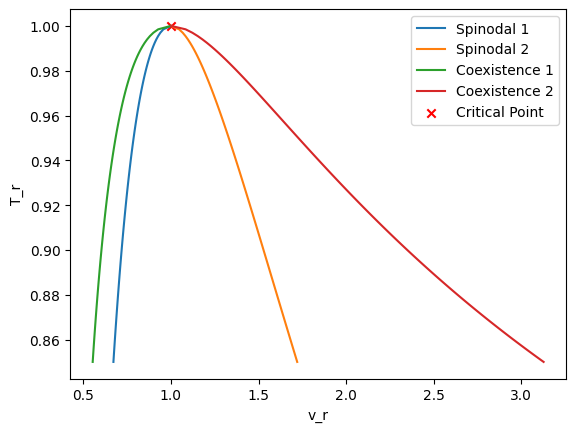

In [10]:
Ts = np.linspace(0.85, 1, 100)
v_spin_1 = []
v_spin_2 = []
v_coex_1 = []
v_coex_2 = []
for T in Ts:
    v_s1, v_s2, v_c1, v_c2 = T_step(T)
    v_spin_1.append(v_s1)
    v_spin_2.append(v_s2)
    v_coex_1.append(v_c1)
    v_coex_2.append(v_c2)

plt.plot(v_spin_1, Ts, label='Spinodal 1')
plt.plot(v_spin_2, Ts, label='Spinodal 2')
plt.plot(v_coex_1, Ts, label='Coexistence 1')
plt.plot(v_coex_2, Ts, label='Coexistence 2')
plt.scatter(1, 1, marker='x', label='Critical Point', color='r')
plt.xlabel('v_r')
plt.ylabel('T_r')
plt.legend()
plt.show()

The fluid is unstable between the blue and orange curves, metastable between the green and blue curves and the orange and red curves, and it globally stable outside the green and red curves.